# Calculation of bulk density and effective atomic number from dual energy CT data

**Brendon Hall, [Enthought](www.enthought.com)**

In dual energy CT scanning, the specimen is scanned twice at two different energy levels.  At higher energies (above 100 kV), x-rays interact with matter mainly through Compton scattering.  The amount of Compton scattering is proportional to the electron density (and thus bulk density).  At x-ray energies below 100 kV, the predominant interaction mechanism is photoelectric absorbtion which is proportional to the effective (bulk) atomic number.

In this analysis, we employ the method proposed by Siddiqui and Khamees (2004) to calculate bulk density $\rho_b$ and effective atomic number $Z_{eff}$ from the dual energy CT data.  They give the following equations to calcluate density from the high and low energy data:

$$m \times CTN_{low} + p \times CTN_{high} + q = \rho_b$$

$$r \times CTN_{low} + s \times CTN_{high} + t = \left[0.9342 \times \rho_b + 0.1759\right] \times Z_{eff}^{3.6}$$

$CTN_{low}$ and $CTN_{high}$ are the CT numbers of the low and high scans, respectively.  The coefficients $m$, $p$, $q$, $r$, $s$ and $t$ need to be determined by a calibration process.  This can be done by performing a dual energy scan of 3 different materials of known $\rho_b$ and $Z_{eff}$ and obtaining the $CTN_{low}$ and $CTN_{high}$ response.  This will give three equations to solve the three unknowns, and the coefficients can be determined.

Weatherford Labs has performed this calibration process, and supplied the following coefficient values.

|Coefficient|Value|
|:-:|:-:|
|m|-1.17847|
|p|2.341677|
|q|1743.256| 
|r|54221.69| 
|s|-65748.2|
|t|-1.3e7|

The following will demonstrate how to use these values to calculate $\rho_b$ and $Z_{eff}$ from the CT data in the Virtual Core project directory.  We begin by loading some libraries we'll need to read and display the CT data.

In [43]:
%matplotlib inline
import pylab as plt
import tables
import numpy as np

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

For this example, we will calculate $\rho_b$ and $Z_{eff}$ for one section.  We need to specify the filenames to be used.  The project data is stored in a number of `.h5` files; one for each scanned section.  These don't correspond exactly to the official expedition sections, as many were too long to be scanned at once and had to be done in stages.  Make sure the low and high files point to the same depth range.

In [44]:
high_filename = '/media/brendon/VirtualCoreData/Chicxulub/364_VirtualCore/ct_697_09-698_09.h5'
low_filename = '/media/brendon/VirtualCoreData/Chicxulub/364_VirtualCore/low_697_09-698_09.h5'

Now we read the data from the files.  For this demonstration, we will use the original data.  This is data that hasn't been modified by any processing (its the raw data received from Weatherford), so the CT numbers are compatible with the calibration coefficients.

We will use the `xz_slice_original` data to get an slice of the entire section.  We will also get a cross section from the original 3D volume of CT numbers.  Here we grab the 100th slice.

In [45]:
high_data_set = tables.open_file(high_filename, 'r')
high_xz_slice = high_data_set.root.CT.xz_slice_original.read().astype(float)
high_xsection = high_data_set.root.CT.volume_original.read()[100].astype(float)
high_data_set.close()

low_data_set = tables.open_file(low_filename, 'r')
low_xz_slice = low_data_set.root.CT.xz_slice_original.read().astype(float)
low_xsection = low_data_set.root.CT.volume_original.read()[100].astype(float)
low_data_set.close()

The raw data are 2D arrays of CT numbers.  The data in this form will make it easy to apply Eqs 1 & 2.  To demonstrate, the data type and shape of the high energy cross section data is:

In [46]:
print type(high_xsection)
print high_xsection.shape

<type 'numpy.ndarray'>
(512, 512)


The cross section is a 512x512 array of CT numbers.  Each cross section corresonds to a single raw CT slice as delivered by Weatherford.  the raw data consisted of an individual file for every slice.  These were combined into efficient 3D arrays during processing.

Let's take a look at the data in a more familiar form.  We'll plot the cross sections of both scans side by side.

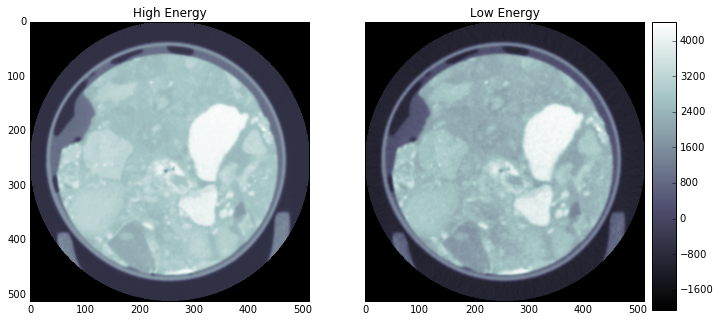

In [47]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True,
                               figsize=(11,5))

ax1.imshow(high_xsection, cmap=plt.cm.bone, aspect='auto')
ax1.set_title('High Energy')

im = ax2.imshow(low_xsection, cmap=plt.cm.bone, aspect='auto')
ax2.set_title('Low Energy')

cax = fig.add_axes([0.91, 0.1, 0.03, 0.8])
fig.colorbar(im, cax=cax)

The raw data clearly shows the tubing and scanning fixture, along with some interstitial fluid.  This won't affect our calculations, but we can remove it for display purposes by defining a circular mask.

In [48]:
xc = 252 #obtained by identifying the center of the core in pixels
yc = 260
r = 200
y,x = np.ogrid[0:512,0:512]
mask = (x-xc)*(x-xc) + (y-yc)*(y-yc) > r*r

high_xsection[mask] = np.NaN
low_xsection[mask] = np.NaN


We can now calculate the bulk density of the cross section.  This is just a linear combination of the high and low energy cross sections.  Using the equations above and the coefficients supplied by Weatherford:

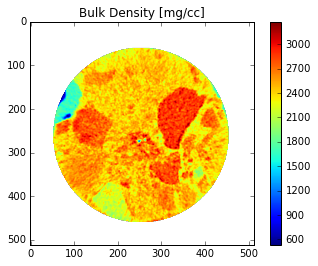

In [49]:
m = -1.17847
p = 2.341677
q = 1743.256

rho_b = m * low_xsection + p * high_xsection + q

plt.imshow(rho_b)
plt.colorbar()
plt.title('Bulk Density [mg/cc]')

The calculation of $Z_{eff}$ is similar, with an additional step to account for the exponent.

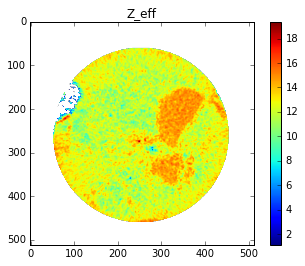

In [50]:
r = 54221.69
s = -65748.2
t = -1.3e7

Z_intermediate = r * low_xsection + s * high_xsection + t 
Z_intermediate = np.divide(Z_intermediate , (0.9342 * rho_b + 0.1759))
Z_eff = Z_intermediate ** (1.0 / 3.6)

plt.imshow(Z_eff)
plt.colorbar()
plt.title('Z_eff')

The procedure is the same to find $\rho_b$ of the XZ slice.

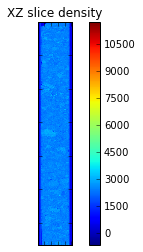

In [57]:
rho_b_slice = m * low_xz_slice + p * high_xz_slice + q

f,ax = plt.subplots()
cax = ax.imshow(rho_b_slice)
f.colorbar(cax)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('XZ slice density')

There are some outliers in the CT data that are giving erroneously high density values.  We're also not interested in the very low density values, which are probably not rock.  Here I clip the maximum density value to 3000 [mg/cc], and ignore any density value below 1900 [mg/cc].

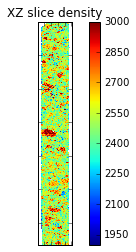

In [52]:
rho_b_slice = np.where(rho_b_slice < 1900, np.nan, rho_b_slice)
rho_b_slice = np.where(rho_b_slice > 3000, 3000, rho_b_slice)

f,ax = plt.subplots()
cax = ax.imshow(rho_b_slice)
f.colorbar(cax)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('XZ slice density')

A similar procedure is applied to obtain $Z_{eff}$ for the XZ slice.

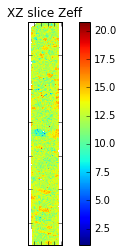

In [53]:
Z_intermediate = r * low_xz_slice + s * high_xz_slice + t 
Z_intermediate = np.divide(Z_intermediate , 
                           (0.9342 * rho_b_slice + 0.1759))
Z_eff_slice = Z_intermediate ** (1.0 / 3.6)

f,ax = plt.subplots()
cax = ax.imshow(Z_eff_slice)
f.colorbar(cax)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('XZ slice Zeff')

The XZ slice data is what was generated for every section and added to the Chicxlub project.  

Now save the $\rho_b$ and $Z_{eff}$ data to an hdf5 file, so it can be used in future analysis...

In [54]:
import h5py
h5file = h5py.File("de_data.h5", mode = "w")
h5file.create_dataset('density_xz_slice', data=rho_b_slice)
h5file.create_dataset('density_xsection', data=rho_b)
h5file.create_dataset('Z_eff_xz_slice', data=Z_eff_slice)
h5file.create_dataset('Z_eff_xsection', data=Z_eff)
h5file.close()